In [5]:
# Install libraries (run in terminal or notebook cell)
!pip install transformers datasets torch pandas scikit-learn
!pip install pandas datasets transformers torch scikit-learn matplotlib
!pip install transformers datasets scikit-learn torch pandas fsspec huggingface_hub

  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)


In [19]:
import pandas as pd
import fsspec

# Make sure you have fsspec and huggingface_hub installed
# pip install fsspec huggingface_hub

df = pd.read_parquet(
    "hf://datasets/sealuzh/app_reviews/data/train-00000-of-00001.parquet",
    filesystem=fsspec.filesystem("hf")
)

print(df.head())# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

              package_name                                             review  \
0  com.mantz_it.rfanalyzer  Great app! The new version now works on my Bra...   
1  com.mantz_it.rfanalyzer  Great It's not fully optimised and has some is...   
2  com.mantz_it.rfanalyzer  Works on a Nexus 6p I'm still messing around w...   
3  com.mantz_it.rfanalyzer  The bandwidth seemed to be limited to maximum ...   
4  com.mantz_it.rfanalyzer  Works well with my Hackrf Hopefully new update...   

              date  star  
0  October 12 2016     4  
1   August 23 2016     4  
2   August 04 2016     5  
3     July 25 2016     3  
4     July 22 2016     5  


In [20]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Drop any rows with missing values
df.dropna(subset=["review", "star"], inplace=True)


In [21]:
# Distribution of star ratings
print(df['star'].value_counts())

# Average rating
print(f"Average Rating: {df['star'].mean():.2f}")


star
5    174374
1     39984
4     37247
3     23196
2     13264
Name: count, dtype: int64
Average Rating: 4.02


In [ ]:
# Create a sentiment label: positive (4-5) = 1, negative (1-2) = 0, neutral (3) = drop or label separately
df = df[df['star'] != 3]  # Optional: remove neutral reviews
df['label'] = df['star'].apply(lambda x: 1 if x >= 4 else 0)


/tmp/ipython-input-6-2201673042.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['star'].apply(lambda x: 1 if x >= 4 else 0)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-8-1782019205.py:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,0.522500
20,0.551500
30,0.402800
40,0.372100
50,0.290700
60,0.488500
70,0.382800
80,0.376200
90,0.380200
100,0.279600


              precision    recall  f1-score   support

    Negative       0.74      0.66      0.69        76
    Positive       0.92      0.94      0.93       324

    accuracy                           0.89       400
   macro avg       0.83      0.80      0.81       400
weighted avg       0.89      0.89      0.89       400



<Figure size 500x500 with 0 Axes>

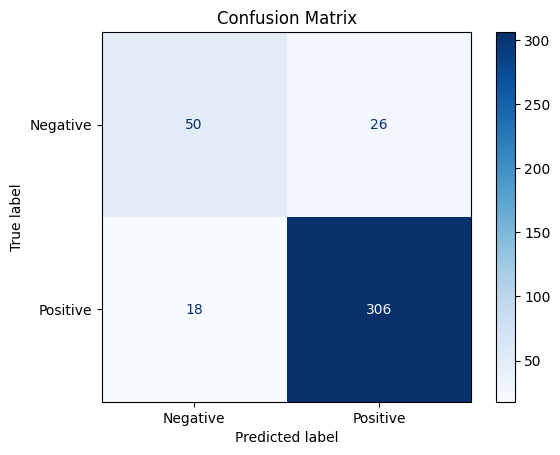

In [8]:
import pandas as pd
import fsspec
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Load dataset from Hugging Face
df = pd.read_parquet(
    "hf://datasets/sealuzh/app_reviews/data/train-00000-of-00001.parquet",
    filesystem=fsspec.filesystem("hf")
)

# Preprocess: keep binary labels only
df = df.dropna(subset=["review", "star"])
df = df[df["star"] != 3]
df["label"] = df["star"].apply(lambda x: 1 if x >= 4 else 0)

# Use a smaller subset for CPU training
df_small = df.sample(n=2000, random_state=42)

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_small["review"].tolist(), df_small["label"].tolist(), test_size=0.2, random_state=42
)

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(texts):
    return tokenizer(texts, truncation=True, padding=True, max_length=512)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# Prepare datasets
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})

val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": val_labels
})

# Load model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

# Training arguments (CPU-optimized)
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    save_strategy="no",
    logging_strategy="steps",
    logging_steps=10,
    disable_tqdm=False
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

# Save the model
model.save_pretrained("./distilbert-sentiment-model")
tokenizer.save_pretrained("./distilbert-sentiment-model")

# 12. Evaluate and get predictions
preds_output = trainer.predict(val_dataset)

y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

# 13. Print classification report
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

# 14. Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="./distilbert-sentiment-model")

print(classifier("This app is absolutely fantastic!"))
print(classifier("I hate this app. It crashes all the time."))


Device set to use cuda:0


[{'label': 'LABEL_1', 'score': 0.9889195561408997}]
[{'label': 'LABEL_0', 'score': 0.8702137470245361}]


In [ ]:
eval_result = trainer.evaluate()
print(eval_result)


{'eval_loss': 0.2857297956943512, 'eval_accuracy': 0.895, 'eval_f1': 0.9357798165137615, 'eval_runtime': 2.6115, 'eval_samples_per_second': 153.169, 'eval_steps_per_second': 9.573, 'epoch': 1.0}


In [ ]:
!pip install fsspec huggingface_hub


In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="./distilbert-sentiment-model")

samples = [
    "This app is amazing. I use it every day!",
    "Terrible update. Keeps crashing and full of bugs.",
    "Not bad, but needs improvement in performance."
]

results = classifier(samples)

for text, pred in zip(samples, results):
    print(f"'{text}' → {pred['label']} (confidence: {pred['score']:.2f})")


Device set to use cuda:0


'This app is amazing. I use it every day!' → LABEL_1 (confidence: 0.99)
'Terrible update. Keeps crashing and full of bugs.' → LABEL_0 (confidence: 0.86)
'Not bad, but needs improvement in performance.' → LABEL_1 (confidence: 0.96)


In [ ]:
from transformers import pipeline

# Load the pipeline with your trained model
classifier = pipeline("sentiment-analysis", model="./distilbert-sentiment-model")

# Test on custom app reviews
reviews = [
    "Absolutely love this app! It works perfectly.",
    "I hate the new update. It ruined everything.",
    "App is okay, but crashes sometimes.",
    "Best tool I've ever used for radio analysis.",
    "Very slow and buggy on my device."
]

results = classifier(reviews)

# Print predictions
for review, result in zip(reviews, results):
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {result['label']} (Confidence: {result['score']:.2f})\n")


Device set to use cuda:0


Review: Absolutely love this app! It works perfectly.
Predicted Sentiment: LABEL_1 (Confidence: 0.99)

Review: I hate the new update. It ruined everything.
Predicted Sentiment: LABEL_0 (Confidence: 0.86)

Review: App is okay, but crashes sometimes.
Predicted Sentiment: LABEL_1 (Confidence: 0.84)

Review: Best tool I've ever used for radio analysis.
Predicted Sentiment: LABEL_1 (Confidence: 0.99)

Review: Very slow and buggy on my device.
Predicted Sentiment: LABEL_0 (Confidence: 0.80)



In [ ]:
# Evaluate the model on the validation dataset
eval_result = trainer.evaluate()

print("🔍 Evaluation Results:")
for k, v in eval_result.items():
    print(f"{k}: {v:.4f}")


🔍 Evaluation Results:
eval_loss: 0.2857
eval_accuracy: 0.8950
eval_f1: 0.9358
eval_runtime: 2.6160
eval_samples_per_second: 152.9080
eval_steps_per_second: 9.5570
epoch: 1.0000


In [ ]:
# Make predictions
predictions = trainer.predict(val_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=1)

# Print first few
for i in range(5):
    print(f"Review: {val_texts[i]}")
    print(f"Actual Label: {y_true[i]}, Predicted: {y_pred[i]}")
    print()


Review: Some good features  but terribly annoying banner adds For an app that is seemingly privacy conscious  allowing an annoying  blinking """"""""""""""""1 virus found"""""""""""""""" banner adds is such a shame and makes me no longer trust the integrity of the app.""
Actual Label: 0, Predicted: 1

Review: Thanks again
Actual Label: 1, Predicted: 1

Review: Love Galicia
Actual Label: 1, Predicted: 1

Review: Arbaz Nice
Actual Label: 1, Predicted: 1

Review: Saturation Just love how it allows to play with colors and saturation.
Actual Label: 1, Predicted: 1



In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))


              precision    recall  f1-score   support

    Negative       0.74      0.68      0.71        76
    Positive       0.93      0.94      0.94       324

    accuracy                           0.90       400
   macro avg       0.84      0.81      0.82       400
weighted avg       0.89      0.90      0.89       400



In [ ]:
from transformers import pipeline

# Load the fine-tuned model from your results folder
classifier = pipeline("sentiment-analysis", model="distilbert-sentiment-model")


# Test on new sentences
examples = [
    "I love this app! It works flawlessly.",
    "This app is terrible. Crashes all the time.",
    "Not bad, but could be improved.",
    "Absolutely fantastic experience!"
]

results = classifier(examples)

for text, result in zip(examples, results):
    print(f"Text: {text}")
    print(f"Prediction: {result['label']} (score: {result['score']:.4f})\n")

Device set to use cuda:0


Text: I love this app! It works flawlessly.
Prediction: LABEL_1 (score: 0.9876)

Text: This app is terrible. Crashes all the time.
Prediction: LABEL_0 (score: 0.8400)

Text: Not bad, but could be improved.
Prediction: LABEL_1 (score: 0.9828)

Text: Absolutely fantastic experience!
Prediction: LABEL_1 (score: 0.9881)



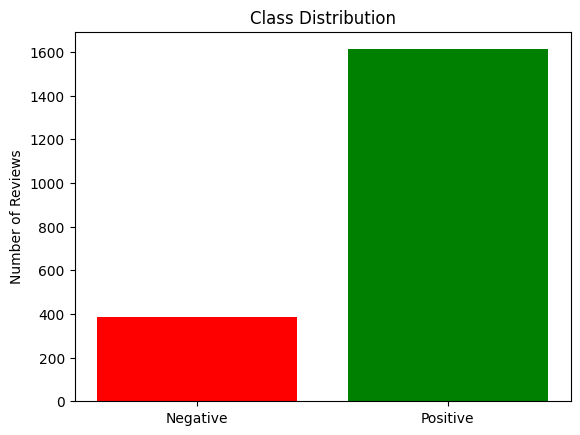

In [ ]:
import matplotlib.pyplot as plt

# Assuming df_small is your DataFrame with 'label' column
label_counts = df_small['label'].value_counts().sort_index()

plt.bar(['Negative', 'Positive'], label_counts, color=['red', 'green'])
plt.title("Class Distribution")
plt.ylabel("Number of Reviews")
plt.show()


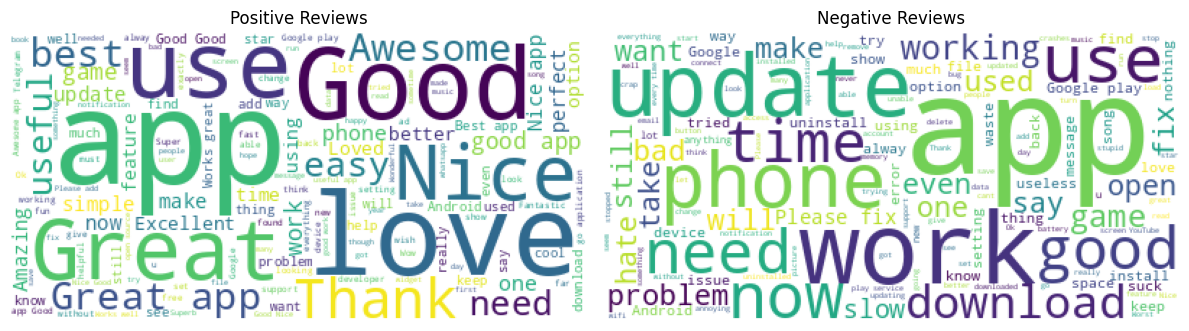

In [9]:
from wordcloud import WordCloud

# Combine reviews
positive_text = " ".join(df[df['label'] == 1]['review'].dropna().astype(str))
negative_text = " ".join(df[df['label'] == 0]['review'].dropna().astype(str))

# WordClouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(background_color='white').generate(positive_text))
plt.axis('off')
plt.title("Positive Reviews")

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(background_color='white').generate(negative_text))
plt.axis('off')
plt.title("Negative Reviews")

plt.tight_layout()
plt.show()
